In [ ]:
import random
import math


##################                                                  ##################
##################  Classes Used to Define Model Setup and Actions  ##################
##################                                                  ##################
class Stage(): # Queueing System
    
    class Server(): # Server
        def __init__ (self,index,id,mu,ctype_mus = None):
            self.id = id
            self.index=index
            self.mu = mu
            self.ctype_mus = ctype_mus
            self.customer = None
            self.nextservice=math.inf
        def NextService(self,customer,clock):
            self.customer = customer
            self.customer.currentnode = self.index
            self.customer.startservice = clock
            if self.ctype_mus == None:
                self.nextservice = clock + random.expovariate(self.mu)
            else:
                self.nextservice = clock + random.expovariate(self.ctype_mus[self.customer.attributes[self.index]])
            return(self.nextservice)
    
    def __init__(self, index, mu, servers, priority = "FCFS", N = math.inf,  ctype_mus=None):
        self.index=index
        self.N =N
        self.n = 0
        self.mu = mu
        self.s = servers
        self.queue = []
        self.systemsizes=[]
        self.pi_n = []
        self.nextservice = math.inf
        self.serverlist = []
        self.priority = priority
        for server in range(self.s):
            self.serverlist.append(self.Server(self.index,server, mu,ctype_mus))
            
        
    def AddtoQ(self,customer,clock):
        self.queue.append(customer)
        customer.clockin = clock
        self.n +=1 
    #def RemovefromQ():
    
    def RemovefromQ(self, serviceinfo):
        customer = self.serverlist[serviceinfo[1].id].customer
        customer.clockout = serviceinfo[2]
        customer.AddWaitTime()
        customer.currentnode = None
    
    def Serve(self, serviceinfo):
        customer = self.serverlist[serviceinfo[1].id].customer
        self.RemovefromQ(serviceinfo) # pops Customer out of que
        self.ResetServer(serviceinfo)
        self.n -=1

        return(customer) # pops out customer for next queue
    def ResetServer(self,serviceinfo):
        self.serverlist[serviceinfo[1].id].customer=None
        self.serverlist[serviceinfo[1].id].nextservice=math.inf
    def Sort(self):
        if self.priority == "Classes":
            self.queue = sorted(self.queue, key=lambda customer: customer.ctype)
        else:
            pass
            
class Exit(Stage):
    def __init__(self, index):
        _mu = 0
        servers = 0
        super(Exit,self).__init__(self,index,_mu,servers)
        
class CustomerClass():
    
    
                
    def __init__(self,ctypelist,ctyperate,ctypedictionary):
        self.subclasslist = []
        self.waittime = None
        for ctype in ctypelist:
            self.subclasslist.append(self.Subclass(ctype,ctyperate[ctype]))
            
    class Subclass():
        def __init__ (self, ctype,ctyperate):
            clock = 0
            self.subwaittime = None
            self.ctype = ctype
            self.ctyperate = ctyperate
            self.nextarrival = self.NextArrival(self.ctype,clock)
        def NextArrival(self,ctype,clock):
            self.nextarrival = clock + random.expovariate(self.ctyperate)
            return(self.nextarrival)
        
class Customer(CustomerClass):    
    def __init__(self,ctype):
        from numpy.random import choice
        self.ctype = ctype
        self.ctype2 = choice([0,1],p=[.8,.2])
        self.attributes = [self.ctype,self.ctype2]
        self.clockin = None
        self.startservice = None
        self.clockout = None
        self.currentNode = None
        self.waittimelist = []
        
    def AddWaitTime(self):
        self.waittimelist.append([self.clockin,self.startservice,self.clockout])
        self.clockin = None
        self.startservice = None
        self.clockout = None
  
  
  
##################                         ##################
##################  General Model Actions  ##################
##################                         ##################  
    
def GenerateArrival(Classes,ctype,clock):
    Classes.subclasslist[ctype].NextArrival(ctype,clock)
    return()
def FindNextArrival(Classes):
    nextarrival = [None,math.inf]
    for subclass in Classes.subclasslist:
        if subclass.nextarrival < nextarrival[1]:
            nextarrival = [subclass.ctype, subclass.nextarrival]
    return(nextarrival)
def Independentarrival(rate):
    return(random.expovariate(rate))   
def GenerateServiceTimes(Queuelist,clock):
     ### Sorts node with premtive priority
    for Node in Queuelist:
        Node.Sort()
        if len(Node.queue) > 0: #If customers enter the Q # This line is redundant for performance
            for server in Node.serverlist:
                if len(Node.queue) > 0: #If customers enter the Q
                    if server.customer == None:
                        customer = Node.queue[0]
                        server.NextService(customer,clock) #Starts Next Service
                        Node.queue.remove(customer) # Removes Customer from queue, the patient is now being served.
            pass
    return()
def FindNextServiceTimes(Queuelist):
    nextservice = [None,None,math.inf]
    for Node in Queuelist:
        for Server in Node.serverlist:
            if Server.nextservice < nextservice[2]:
                nextservice = [Node,Server,Server.nextservice]
    return(nextservice)



##################                      ##################
##################   Model Evaluation   ##################
##################                      ##################
def CalcSystemStates(Queuelist):
    for Node in Queuelist:
        s=0
        for server in Node.serverlist:
            if server.customer != None:
                s+=1
        Node.systemsizes.append(len(Node.queue)+s)
    return()
def CalcSystemStats(Queuelist):
    for Node in Queuelist:
            for i in range(max(Node.systemsizes)):
                Node.pi_n.append(Node.systemsizes.count(i)/len(Node.systemsizes))
    return()
def CalcWaitTime(Queuelength,customersdone,ctypelist = None):
    import numpy as np
    Waittimes =[]
    ClassTimes = []
    for i in range(Queuelength):
        times = []
        qtimes = []
        ClassWaittimes = []
        ClassQWaittimes = []
        ClassTimes = []
        for ctype in ctypelist:
            ClassWaittimes.append([])
            ClassQWaittimes.append([])
            
        for customer in customersdone:
            time = customer.waittimelist[i][2]-customer.waittimelist[i][0]
            qtime = customer.waittimelist[i][1]-customer.waittimelist[i][0]
            ClassWaittimes[customer.ctype].append(time)
            ClassQWaittimes[customer.ctype].append(qtime)
            times.append(time)
            qtimes.append(qtime)
            
        for ctype in ctypelist:
            ClassTimes.append([np.mean(ClassWaittimes[ctype]),np.mean(ClassQWaittimes[ctype])])
        Waittimes.append([np.mean(qtimes), np.mean(times),ClassTimes])
        #NodeQueueTime.append(np.mean(qtimes))
    #Waittimes = [NodeWaitTime, NodeQueueTime]


    return(Waittimes)

    



In [166]:
import numpy as np
#Arrival Process
#Define Clock
clock = 0
runtime = 1000
systemcheckinterval = 0.25
systemcheck = 100
#######System Parameters#######
K=60 #let K be our total system capacity
N=0 #let N be the Total number in the sys
Nlist = []

#########Create Initial Arrivals##########
#ctypelist = [0,1] # Customer Classes
ctypelist =[0,1,2]
ctypedictionary = ["Cripple","Elderly","Regular","Cripple"] #Customer Class Descriptions
ctyperate = [5,7,11] #Customer Class Arrival Rates
ctypemu = [15,15,15]
ctype2mu = [12,12]
Classes = CustomerClass(ctypelist,ctyperate,ctypedictionary)

####################################
#Define The list of Queues our Riders will be going through
Queuelist = [] # Empty List of Queues,  follows form [M/M/2/FCFS/N, M/M/2/FCFS/N]
Queuelist.append(Stage(0,15,2,priority="Classes", ctype_mus= ctypemu))
Queuelist.append(Stage(1,12,2,ctype_mus=ctype2mu))
Queuelist.append(Exit(2))   #Finished Patients


#Let N represent The Max number on a bus
customersdone = []
#Arrival into M/M/2/FCFS/N Bus Board Node
#Transition from Bus Board Node to M/M/2/N Bus Exit Node
#Exit from Bus Exit Node

#while len(customersdone) <=  K:
while clock <= runtime:
        nextservice = [None,None,math.inf]
        #nextarrival = [0,clock + random.expovariate(20)]
        
        GenerateServiceTimes(Queuelist,clock)
        nextservice = FindNextServiceTimes(Queuelist)
        nextarrival = FindNextArrival(Classes)
        if (systemcheck <= nextarrival[1]) and (systemcheck <= nextservice[2]):
                CalcSystemStates(Queuelist)
                systemcheck += systemcheckinterval
        if nextarrival[1] <= nextservice[2]:
                clock = nextarrival[1]
                customer = Customer(nextarrival[0])
                if N < K:
                        #Queuelist[0].queue.append(customer) # Adds Customer to First Queue # This method is faster but less Dynamic
                        Queuelist[0].AddtoQ(customer,clock)
                        N+=1
                GenerateArrival(Classes,customer.ctype,clock)
                customer=None
                nextarrival = [None, math.inf]
                
        elif nextservice[2] <= nextarrival[1]:
                clock = nextservice[2]
                customer = Queuelist[nextservice[0].index].Serve(nextservice) #Serves Customer
                
                ###Insert Birth Death Between Queues ####
                
                #Queuelist[nextservice[0].index+1].queue.append(customer) # Bumps Customer to next Queue
                Queuelist[nextservice[0].index+1].AddtoQ(customer,clock) # This method is faster but less Dynamic
                if nextservice[0].index+1 == 2: # Final Stage
                        customer.clockout = nextservice[2]
                        customersdone.append(customer)
                        N -= 1
                        
                customer = None
                nextservice = [None,None,math.inf]
        Nlist.append(N)
CalcSystemStats(Queuelist)
meanN = np.mean(Nlist)
        



In [173]:
import numpy as np
print(Queuelist[1].pi_n)
print(np.mean(Queuelist[1].systemsizes))
print(np.mean(Queuelist[0].systemsizes))

print(meanN)


[0.01999444598722577, 0.04609830602610386, 0.03332407664537628, 0.04054429325187448, 0.03332407664537628, 0.03193557345181894, 0.036378783671202446, 0.03526798111635657, 0.02915856706470425, 0.02582615940016662, 0.03721188558733685, 0.03165787281310747, 0.02832546514856984, 0.026936961955012495, 0.021382949180783116, 0.02054984726464871, 0.0197167453485143, 0.016384337683976673, 0.021382949180783116, 0.013329630658150514, 0.013885031935573451, 0.014995834490419328, 0.016384337683976673, 0.013885031935573451, 0.012218828103304638, 0.018328242154956955, 0.01721743960011108, 0.01444043321299639, 0.016384337683976673, 0.01666203832268814, 0.010552624271035824, 0.01666203832268814, 0.011108025548458762, 0.016106637045265205, 0.013051930019439044, 0.013885031935573451, 0.012496528742016106, 0.011108025548458762, 0.011108025548458762, 0.009997222993612885, 0.009997222993612885, 0.013607331296861983, 0.009997222993612885, 0.011385726187170231, 0.007497917245209664, 0.00860871980005554, 0.01138

In [174]:
NodeWaitTime = CalcWaitTime(2,customersdone,[0,1,2])
print (NodeWaitTime[1][2])
print (NodeWaitTime[1])

[[np.float64(0.8555101660452451), np.float64(0.7730946348562092)], [np.float64(0.8542021249842917), np.float64(0.7701910308283304)], [np.float64(0.8687249023954232), np.float64(0.785337268051542)]]
[np.float64(0.7781504873096459), np.float64(0.8615145711677196), [[np.float64(0.8555101660452451), np.float64(0.7730946348562092)], [np.float64(0.8542021249842917), np.float64(0.7701910308283304)], [np.float64(0.8687249023954232), np.float64(0.785337268051542)]]]


In [117]:
customersdone[50].clockout-customersdone[50].clockin

0.0

In [118]:
customersdone[1254].waittimelist

[[53.75220632999845, 53.75220632999845, 53.79766877626636],
 [53.79766877626636, 55.050467570674776, 55.0521935580444]]

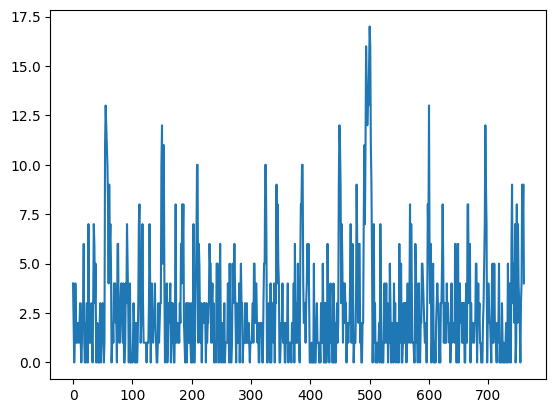

In [82]:
import matplotlib.pyplot as plt
plt.plot(Queuelist[0].systemsizes)
plt.show()

In [171]:
i = 5000
import numpy as np
waittimes = []
while i < len(customersdone):
    waittimes.append(customersdone[i].waittimelist[1][2]-customersdone[i].waittimelist[1][0])
    i+=1
np.mean(waittimes)

np.float64(0.8915441912373335)

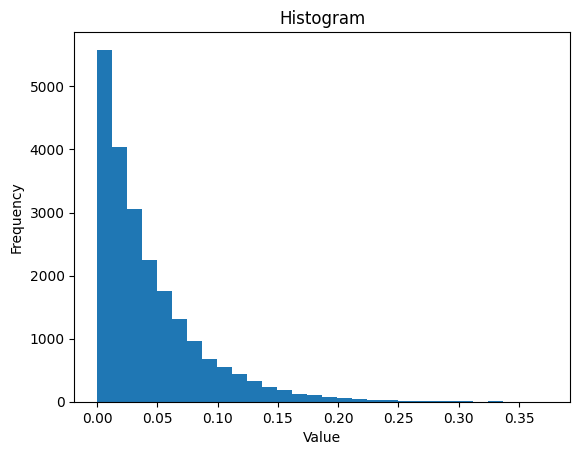

22.993701617871537


In [168]:
i = 1000
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import expon
data = []
while i < len(customersdone):
    data.append(customersdone[i].waittimelist[1][2]-customersdone[i-1].waittimelist[1][2])
    i+=1
plt.hist(data, bins=30)
plt.title('Histogram')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()
l = expon.fit(data,floc=0)
print(1/l[1])

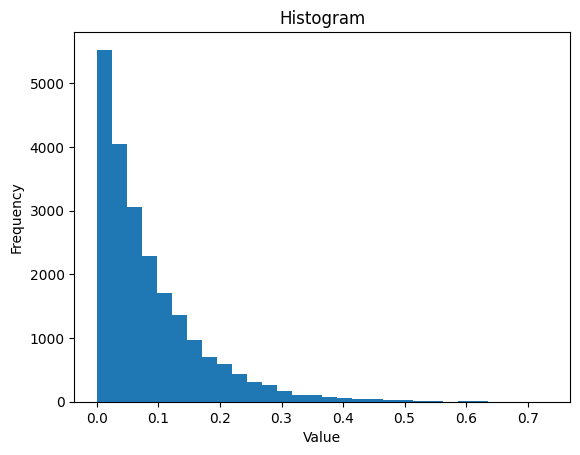

11.764863628273284


In [169]:
i = 1000
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import expon,norm
data = []
while i < len(customersdone):
    data.append(abs(customersdone[i].waittimelist[0][2]-customersdone[i-1].waittimelist[0][2]))
    i+=1
plt.hist(data, bins=30)
plt.title('Histogram')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()
l = expon.fit(data,floc=0)
print(1/l[1])